In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy  as np
import seaborn as sns
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "notebook"
path = './data/'
pd.options.display.max_rows = 150
pd.options.display.max_columns = 350
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터만들기

## 1. 데이터로드

In [14]:
sigungu = pd.read_csv(path+'sigungu_imp_10.csv', encoding='cp949')
sigungu_3 = pd.read_csv(path+'시군구별지역안전지표_2015.csv', encoding='cp949')

In [15]:
y_bin = sigungu.iloc[:,-7:]    #등급(binary)
y_deci = sigungu_3.iloc[:,-7:] #등급(1-5)
X = sigungu.iloc[:,4:-7]       #독립변수X
name = sigungu.iloc[:,:4]      #이름

In [16]:
y_bin.columns = ['fire','transport','disaster','crime','accident','suicide','infection']

In [17]:
sigungu_xy = pd.concat([X,y_bin], axis=1)
sigungu_nxy = pd.concat([name, sigungu_xy,y_deci], axis=1)
sigungu_nxy.shape

(226, 162)

## 2. 지표추가

In [18]:
## 가설: 이혼부모 + 미성년자녀 가구가 많은 지역은 소년범죄율이 높을 것이다. 소년폭력범죄율이 높을 것이다.
## 재판이혼이 많은 지역은 범죄가 많을 것이다.
## 재판이혼이 많은 지역은 소년범죄가 많을 것이다

*시도변환

In [19]:
#시도변환
이혼통계 = 'C:/Users/COM/Desktop/이혼통계/'
시도변환 = pd.read_csv(이혼통계+'시도변환.csv', encoding='cp949')
시도변환.head(3)

,풀,요약
0,강원도,강원
1,경기도,경기
2,경상남도,경남


*시군구별소년인구

In [20]:
#시군구별 소년인구 : 범죄비율을 구하기 위함
소년인구 = pd.read_csv(이혼통계+'시군구별소년인구.csv', encoding='cp949')
시군구별소년인구 = 소년인구.groupby(['시도','시군구']).sum().reset_index()
시군구별소년인구.head(3)
# 전체데이터프레임에 지표(시군구별소년인구)추가
sigungu_nxy= sigungu_nxy.merge(시군구별소년인구,on=['시도','시군구'], how='left')

*전국범죄건수

In [21]:
# 범죄건수(소년,성인)추가-지방
지방범죄 = pd.read_csv(이혼통계+'범죄발생.csv', encoding='cp949')
# df = 지방범죄.loc[:,['시도','시군구','합계_소년','합계_일반','폭력범_소년','폭력범_일반']]
지방범죄.replace(시도변환.요약.tolist(), 시도변환.풀.tolist(), inplace=True)
지방범죄.drop(['지능풍속범_소년','기타형법범_소년','특별법범_소년'],axis=1,inplace=True)
지방범죄.drop(['지능풍속범_일반','기타형법범_일반','특별법범_일반'],axis=1,inplace=True)
지방범죄.head(3)

,시도,시군구,합계_소년,강력범_소년,절도범_소년,폭력범_소년,합계_일반,강력범_일반,절도범_일반,폭력범_일반
0,대구광역시,서구,294.0,4.0,89.0,81.0,10264.0,96.0,1159.0,1960.0
1,전라남도,장성군,41.0,3.0,12.0,15.0,1334.0,21.0,195.0,200.0
2,부산광역시,진구,1099.0,28.0,396.0,214.0,19127.0,309.0,3323.0,3093.0


In [22]:
# 범죄건수(소년,성인)추가-서울
# 서울-소년범죄
서울소년범죄 = pd.read_csv(이혼통계+'2015년 관서별 청소년 5대범죄 현황.csv', encoding='cp949')
서울소년범죄 = 서울소년범죄.groupby('시군구').sum().reset_index()
서울소년범죄.columns = ['시군구','살인_소년','강도_소년','강간추행_소년','절도_소년','폭력_소년']
서울소년범죄
# 서울-일반범죄
서울일반범죄 = pd.read_csv(이혼통계+'2015년 관서별 범죄 발생 현황.csv', encoding='cp949')
서울일반범죄  = 서울일반범죄.loc[서울일반범죄.발생검거=='발생']
서울일반범죄2= 서울일반범죄.pivot_table(values='건수', index=['구분'], columns=['죄종']).reset_index()
서울일반범죄2 = pd.concat([서울소년범죄.시군구,서울일반범죄2],axis=1)
서울일반범죄2 = 서울일반범죄2.groupby('시군구').sum().reset_index()
서울일반범죄2.columns = ['시군구','살인_일반','강도_일반','강간추행_일반','절도_일반','폭력_일반']
서울일반범죄2
# 서울-소년범죄+일반범죄
서울범죄 = 서울소년범죄.merge(서울일반범죄2)
서울범죄['시도']='서울특별시'
서울범죄['강력범_소년']=서울범죄.살인_소년+서울범죄.강도_소년+서울범죄.강간추행_소년
서울범죄['강력범_일반']=서울범죄.살인_일반+서울범죄.강도_일반+서울범죄.강간추행_일반
서울범죄.drop(['살인_소년','강도_소년','강간추행_소년','살인_일반','강도_일반','강간추행_일반'],axis=1,inplace=True)
#서울-소년범죄+일반범죄 열순서변경,이름변경
서울범죄= 서울범죄.loc[:,['시도', '시군구',
           '강력범_소년', '절도_소년', '폭력_소년',
           '강력범_일반', '절도_일반', '폭력_일반']]
서울범죄.columns=['시도', '시군구', '강력범_소년', '절도범_소년', '폭력범_소년', '강력범_일반', '절도범_일반', '폭력범_일반']
서울범죄.head(3)

,시도,시군구,강력범_소년,절도범_소년,폭력범_소년,강력범_일반,절도범_일반,폭력범_일반
0,서울특별시,강남구,7,203,132,318,2411,2465
1,서울특별시,강동구,16,167,211,166,2366,2712
2,서울특별시,강북구,7,146,209,174,1434,2649


In [23]:
#범죄건수=서울+지방
전국범죄 = pd.concat([지방범죄,서울범죄]) #열순서 가나다순으로됨
전국범죄 = 전국범죄.loc[:,['시도','시군구',
                      '강력범_소년','절도범_소년','폭력범_소년',
                      '강력범_일반','절도범_일반','폭력범_일반']]
전국범죄.head(3)
# 전체데이터프레임에 지표(범죄건수)추가
sigungu_nxy= sigungu_nxy.merge(전국범죄,on=['시도','시군구'], how='left')
# 파생변수열 추가
sigungu_nxy['소년_합계']=sigungu_nxy.강력범_소년+sigungu_nxy.절도범_소년+sigungu_nxy.폭력범_소년
sigungu_nxy['일반_합계']=sigungu_nxy.강력범_일반+sigungu_nxy.절도범_일반+sigungu_nxy.폭력범_일반

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




*가구주의 혼인상태별 가구구성

In [24]:
#전체가구구성
이혼가구00= pd.read_csv(이혼통계+'가구주이혼가족구성_전체포함.csv',encoding='cp949')
#'시도'열 추가하며 내용 채우기
def 시도자르기(sido):
    minval = 이혼가구00.loc[이혼가구00.행정구역별==sido].index.min()
    maxval = 이혼가구00.loc[이혼가구00.행정구역별==sido].index.max()
    return minval, maxval
sidolst=[]
minlst=[]
maxlst=[]
for sido in 시도변환.풀:
    minval, maxval = 시도자르기(sido)
    sidolst.append(sido)
    minlst.append(minval)
    maxlst.append(maxval)
df = pd.DataFrame({'sido':sidolst,'min':minlst,'max':maxlst}).sort_values(by='min').reset_index().drop('index', axis=1)
df
for i in range(len(df)):
    if i!= 15:
#         print(df.loc[i,'min'], df.loc[i+1,'min']-1)
        이혼가구00.loc[df.loc[i,'min']:df.loc[i+1,'min']-1,'시도'] = df.sido[i]
    else:
#         print(df.loc[i,'min'])
        이혼가구00.loc[df.loc[i,'min']:] = df.sido[i]
#불필요열 삭제
이혼가구00.dropna(inplace=True)
이혼가구00.drop('가구주의 혼인상태',axis=1, inplace=True)
# 시도시군구별로 (지정한연령내) 가구를 구함
전체가구 = 이혼가구00.groupby(['행정구역별','시도']).sum().drop(['가구주의 연령별','항목'],axis=1).reset_index()
전체가구.columns=['시군구','시도','전체가구수']
전체가구.head(3)

,시군구,시도,전체가구수
0,가평군,경기도,33299
1,강남구,서울특별시,425703
2,강동구,서울특별시,326384


In [57]:
#젊은+이혼가구 : 젊은의 기준은 19세~44세
이혼가구 = pd.read_csv(이혼통계+'가구주이혼가족구성.csv', encoding='cp949')
# 이혼가구0 = pd.read_csv(이혼통계+'가구주이혼가족구성2.csv', encoding='cp949')
이혼가구 = 이혼가구.loc[이혼가구['가구주의 연령별']!='55 ~ 59세']
이혼가구 = 이혼가구.loc[이혼가구['가구주의 연령별']!='55 ~ 59세']
이혼가구 = 이혼가구.loc[이혼가구['가구주의 연령별']!='50 ~ 54세']
이혼가구 = 이혼가구.loc[이혼가구['가구주의 연령별']!='45 ~ 49세']
# 이혼가구 = 이혼가구.loc[이혼가구['가구주의 연령별']!='40 ~ 44세']
이혼가구2= 이혼가구.groupby(['시도','시군구','항목']).sum().reset_index() #연령내가 설정한대로 합이 나옴
이혼가구2
이혼가구3=이혼가구2.pivot_table(values='2015 년', index=['시도','시군구'], columns=['항목']).reset_index()
이혼가구4= 이혼가구3.loc[:,['시도','시군구','2세대가구-모+미혼자녀','2세대가구-부+미혼자녀','2세대가구-계','1세대가구-계']]
이혼가구3
이혼가구4

항목,시도,시군구,1세대가구-가구주+기타친인척,1세대가구-가구주+미혼형제자매,1세대가구-계,1세대가구-기타,1세대가구-부부,1세대가구-부부+기타친인척,1세대가구-부부+미혼형제자매,1인가구,2세대가구-계,2세대가구-기타,2세대가구-모+미혼자녀,2세대가구-부+미혼자녀,2세대가구-부부+미혼자녀,2세대가구-부부+미혼자녀+부부미혼형제자매,2세대가구-부부+양친,2세대가구-부부+한부모,2세대가구-조부 또는 조모+미혼손자녀,2세대가구-조부모+미혼손자녀,3세대가구-계,3세대가구-기타,3세대가구-부부+미혼자녀+모친,3세대가구-부부+미혼자녀+부친,3세대가구-부부+미혼자녀+양친,4세대이상 가구,비친족가구,일반가구
0,강원도,강릉시,0.0,15.0,15.0,0.0,0.0,0.0,0.0,358.0,864.0,74.0,644.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,97.0,0.0,0.0,0.0,0.0,10.0,1344.0
1,강원도,강원도,12.0,23.0,47.0,12.0,0.0,0.0,0.0,2699.0,5697.0,406.0,4313.0,978.0,0.0,0.0,0.0,0.0,0.0,0.0,813.0,811.0,2.0,0.0,0.0,7.0,51.0,9314.0
2,강원도,고성군,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,74.0,1.0,47.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,0.0,0.0,0.0,0.0,4.0,135.0
3,강원도,동부,9.0,18.0,35.0,8.0,0.0,0.0,0.0,1798.0,4141.0,284.0,3220.0,637.0,0.0,0.0,0.0,0.0,0.0,0.0,546.0,546.0,0.0,0.0,0.0,7.0,36.0,6563.0
4,강원도,동해시,4.0,0.0,4.0,0.0,0.0,0.0,0.0,144.0,341.0,21.0,248.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,57.0,0.0,0.0,0.0,0.0,0.0,546.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,충청북도,청원구,0.0,7.0,7.0,0.0,0.0,0.0,0.0,474.0,853.0,54.0,609.0,190.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,72.0,0.0,0.0,0.0,0.0,5.0,1411.0
319,충청북도,청주시,25.0,26.0,63.0,12.0,0.0,0.0,0.0,2088.0,3860.0,223.0,2733.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,401.0,401.0,0.0,0.0,0.0,5.0,31.0,6448.0
320,충청북도,충주시,8.0,0.0,8.0,0.0,0.0,0.0,0.0,332.0,926.0,56.0,686.0,184.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,90.0,0.0,0.0,0.0,0.0,10.0,1366.0
321,충청북도,충청북도,37.0,30.0,79.0,12.0,0.0,0.0,0.0,3259.0,6535.0,439.0,4585.0,1511.0,0.0,0.0,0.0,0.0,0.0,0.0,743.0,743.0,0.0,0.0,0.0,5.0,76.0,10697.0


In [26]:
#전체데이터프레임에 지표(이혼가구수+전체가구수) 추가
sigungu_nxy= sigungu_nxy.merge(이혼가구4.merge(전체가구))
#파생변수열 추가
sigungu_nxy['2세대미혼자녀가구합']=sigungu_nxy['2세대가구-모+미혼자녀']+sigungu_nxy['2세대가구-부+미혼자녀']

# 함수선언

In [27]:
#팔레트정의
darkcyan= ['darkcyan','dimgrey']
darkorange= ['darkorange','dimgrey']

### 중앙선그리는 함수

In [28]:
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
def scatter(x, y, color, df, hovername=None,text=False, medianline=False, palette=['mediumorchid','dimgrey'], trendline=None):
    #산점도------
    if text == True:
        fig = px.scatter(df, x=x, y=y, text='시군구',trendline=trendline,
                             hover_name=hovername, color=color, color_discrete_sequence=palette)
        fig.update_traces(textposition='top center')
    else:
        fig = px.scatter(df, x=x, y=y,trendline=trendline,
                         hover_name=hovername, color=color, color_discrete_sequence=palette)
        fig.update_traces(textposition='top center')    
    #중앙값-----
    if medianline==True:
        #x median
        fig.add_trace(go.Scatter(x=[df[x].median()]*2,
                       y=[-10000000,10000000],
                       name="median x: "+str(round(df[x].median(),2)),
                       mode="lines",
                       line = dict(color = ('rgb(0,0,0)'),width=0.5),
                       visible=True,))
        #y median
        fig.add_trace(go.Scatter(x=[-10000000,10000000],
                       y=[df[y].median()]*2,
                       name="median y: "+str(round(df[y].median(),2)),
                       mode="lines",
                       line = dict(color = ('rgb(0,0,0)'),width=0.5),
                       visible=True))
        # 레전이동      fig.update_layout(legend=dict(x=-.05, y=1.15))
    
    #트렌드라인----
    if trendline==True:
        regline = sm.OLS(df[y],sm.add_constant(df[x])).fit().fittedvalues
        fig.add_traces(go.Scatter(x=df[x], y=regline,
                              mode = 'lines',
                              marker_color='black',
                            line = dict(color = ('rgb(0,0,0)'),width=0.5,dash='7px'),
                              name='trend all'))  
    #플롯 레이아웃(xy범위)----
    fig.update_xaxes(range=[df[x].min()*0.8, df[x].max()*1.05]) #min값 음수인지 아닌지 확인 후 범위 조절
    fig.update_yaxes(range=[df[y].min()*0.5, df[y].max()*1.05]) #min값 음수인지 아닌지 확인 후 범위 조절
    fig.show()

### 회귀식기준 위아래 갯수세기 함수

In [29]:
from scipy import stats
def total_regression(x_,y_, totaldf,groupdf):
    #전체에 대한 xy
    x = totaldf[x_].tolist()
    y = totaldf[y_].tolist()
    #전체에 대한 회귀식생성
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    #지표출력
    print(stats.linregress(x,y))
    print('Rsquared=',stats.linregress(x,y)[2]**2)
        #group에 포함되는 xy
    x = groupdf[x_].tolist()
    y = groupdf[y_].tolist()
    y_pred = []
    for i in range(len(x)):
        y_pred.append(slope*np.array(x[i])+intercept)
    upper = 0
    lower = 0
    for i in range(len(y)):
        if y[i]>=y_pred[i]:
            upper +=1
        else:
            lower +=1
    return pd.DataFrame({'':['total','upper','lower'],
                          'count':[len(y),upper,lower],
                          'ratio':[len(y)/len(y), upper/len(y), lower/len(y)]})

### 사분면별 점갯수 세기

In [30]:
# 사분면별 점 갯수 세는 함수
def 사분면별점갯수(x,y,스트링등급,df):
    condlist=[1,(df[스트링등급]=='1'),(df[스트링등급]=='0')]
    for i,cond in enumerate(condlist):
        quad1 = len(df.loc[(df[x]>=df[x].median())&(df[y]>=df[y].median())&cond])
        quad2 = len(df.loc[(df[x]<=df[x].median())&(df[y]>=df[y].median())&cond])
        quad3 = len(df.loc[(df[x]<=df[x].median())&(df[y]<=df[y].median())&cond])
        quad4 = len(df.loc[(df[x]>=df[x].median())&(df[y]<=df[y].median())&cond])
        if i==0:
            total = [quad1,quad2,quad3,quad4]
            tot_12 = quad1+quad2
            tot_34 = quad3+quad4
            tot_14 = quad1+quad4
            tot_23 = quad2+quad3
        elif i==1:
            num1 = [quad1,quad2,quad3,quad4]
            num1_12 = quad1+quad2
            num1_34 = quad3+quad4
            num1_14 = quad1+quad4
            num1_23 = quad2+quad3
        elif i==2:
            num2 = [quad1,quad2,quad3,quad4]
            num2_12 = quad1+quad2
            num2_34 = quad3+quad4
            num2_14 = quad1+quad4
            num2_23 = quad2+quad3
    return pd.DataFrame({'quad':['quad1','quad2','quad3','quad4','1&2','3&4','1&4','2&3'],\
                         '1(색)':num1+[num1_12,num1_34,num1_14,num1_23],\
                         '0(흑)':num2+[num2_12,num2_34,num2_14,num2_23],\
                         'total':total+[tot_12,tot_34,tot_14,tot_23]})

# 그룹나누기

In [31]:
# #1사분면의 모든 주황초록점 : group1, 1사분면 주황점: group2
# sigungu_nxy['group1'] = np.zeros(len(sigungu_nxy))
# sigungu_nxy['group2'] = np.zeros(len(sigungu_nxy))
# sigungu_nxy['group3'] = np.zeros(len(sigungu_nxy))
# sigungu_nxy['group4'] = np.zeros(len(sigungu_nxy))
# #조건을 만족하는 행 인덱스 가져오기
# cond = (sigungu_nxy['2세대미혼자녀가구합']>sigungu_nxy['2세대미혼자녀가구합'].median())
# cond2 = (sigungu_nxy['불안정가구비율']>sigungu_nxy['불안정가구비율'].median())
# group1_index = sigungu_nxy.loc[cond].index
# group2_index = sigungu_nxy.loc[cond&sigungu_nxy.crime_==1].index
# group3_index = sigungu_nxy.loc[cond2].index
# group4_index = sigungu_nxy.loc[cond2&sigungu_nxy.crime_==1].index
# #group1에 속하는 애들을 1로 표시
# sigungu_nxy.loc[sigungu_nxy.index.isin(group1_index),'group1'] = 1
# sigungu_nxy.loc[sigungu_nxy.index.isin(group2_index),'group2'] = 1
# sigungu_nxy.loc[sigungu_nxy.index.isin(group3_index),'group3'] = 1
# sigungu_nxy.loc[sigungu_nxy.index.isin(group4_index),'group4'] = 1
# sigungu_nxy['group1_'] = sigungu_nxy.group1.astype(str)
# sigungu_nxy['group2_'] = sigungu_nxy.group2.astype(str)
# sigungu_nxy['group3_'] = sigungu_nxy.group3.astype(str)
# sigungu_nxy['group4_'] = sigungu_nxy.group4.astype(str)
# # df.columns=['시도','시군구','소년범죄건수','범죄건수','소년폭력범죄건수','폭력범죄건수','소년범죄비율','소년폭력범죄비율']

# 준비

In [32]:
#그림그리기전 스트링열로
#스트링아니면 숫자로 인식해 연속형이 된다고했음
sigungu_nxy['crime_'] = sigungu_nxy.crime.astype(str)
# sigungu_nxy['group1_'] = sigungu_nxy.group1.astype(str)
# sigungu_nxy['group2_'] = sigungu_nxy.group2.astype(str)
# group1['transport_'] = group1.transport.astype(str)
# group2['transport_'] = group2.transport.astype(str)
# group1['group1_'] = group1.group1.astype(str)
# group2['group2_'] = group2.group2.astype(str)

In [55]:
#열추가

sigungu['미혼자녀가구비율1'] = sigungu['2세대미혼자녀가구합']/sigungu['2세대가구-계']
sigungu['미혼자녀가구비율2'] = sigungu['2세대미혼자녀가구합']/sigungu['전체가구수']

sigungu['소년범죄비율']=sigungu['소년_합계']/sigungu['소년인구']
sigungu['소년폭력범죄비율']=sigungu['폭력범_소년']/sigungu['소년인구']

In [56]:
#간단히, 최종열 확인
sigungu = sigungu_nxy
print('shape:', sigungu.shape)
sigungu.head(1)
# msno.matrix(sigungu)

shape: (186, 178)


,년도,시도,시군구,지역,1인가구수,5대범죄 발생건수,가스사고발생건수,가해(타살) 사망자수,감염병 발생건수,감염병 사망자수,건강보험급여실적,건설업 업체수,건설업 종사자수,건축용지 면적,경찰관서수,고령인구수,공무원수(정원),공업지역 면적,교통문화지수,교통사고 발생건수,교통사고 부상자수,교통사고 사망자수,교통사고사망자수(고속도로),구거면적,구거면적 비율,구급발생건수,구조구급 발생건수,구조구급대원수,구조발생건수,급경사지 붕괴위험지구 수,기초수급자수,기초수급자수(65세이상),노인 교통사고 부상자수,노인 교통사고 사망자수,도로면적,도로면적 비율,도로연장,도시지역 면적,도시지역 면적 비율,독거노인수,무면허교통사고 발생건수,반지하가구 수,범죄발생건수(강간.강제추행),범죄발생건수(강도),범죄발생건수(도박),범죄발생건수(마약),범죄발생건수(방화),범죄발생건수(살인),범죄발생건수(약취.유인),범죄발생건수(절도),범죄발생건수(폭력),병상수,보건업 및 사회복지서비스업 종사자수,보행사상자수,보행자전용·우선도로 면적,보행자전용·우선도로 연장,비닐하우스 면적,빈집수,산사태위험지역 면적,상업지역 면적,수계밀도,순이동자수,스트레스인지율,시가화율,시군구내 전입자수,시군구외 전입자수,시도간 전입자수,시도내-시군구간 전입자수,실업률,야간인구수,양호한 주관적 건강수준 인지율,어린이 교통사고 부상자수,어린이 교통사고 사망자수,어린이 아토피,어린이 천식,외국인수,우울감경험률,운전시 안전벨트 착용률,월간음주율,유지면적,유지면적 비율,유치원생수,음식점 및 주점업 업체수,음식점 및 주점업 종사자수,음주교통사고 발생건수,의료기관수(요양기관),의료보장 공.교 가입자수,의료보장 근로자 사업장수,의료보장 사업장수,의료보험료,의료인력,이혼건수,익사자수,인구밀도,인플루엔자 예방접종률,임야 면적,자동차등록대수,자살 사망자수,자연재해 발생건수(10년평균),자연재해 사망자수,자연재해 사망자수(10년평균),자연재해 피해액(10년평균),자연재해 피해자수(10년평균),자연재해위험개선지구 수,장애인수,재난약자수,재정자립도,재정자주도,전기화재발생건수,제방면적,제방면적 비율,제조업 업체수,제조업 종사자수,주간인구지수,주거지역 면적,주민등록인구,주민등록인구(14세이하),주민등록인구(60세이상),주민등록인구(여자),주민등록인구(청소년),지역안전도(관리능력),지역안전도(등급),지역안전도(방재성능),지역안전도(위험환경),지역안전도(점수),질병이환 및 사망외인으로 인한 사망자수,창고 및 운송관련 서비스업 업체수,초등학생수,총 사업체수,총전입자수,추락 사망자수,특수의료장비수,하천면적,하천면적 비율,하천연장,학교수(고등학교),학교수(중학교),학교수(초등학교),해안선 길이,행정구역 면적,혼인귀화자수,화재 발생건수,화재 사망자수,화재 피해액,화재 피해자수,화재구조실적,화재사망자(환산),화재피해 경감액,fire,transport,disaster,crime,accident,suicide,infection,화재,교통,자연재해,범죄,안전사고,자살,감염병,소년인구,강력범_소년,절도범_소년,폭력범_소년,강력범_일반,절도범_일반,폭력범_일반,소년_합계,일반_합계,2세대가구-모+미혼자녀,2세대가구-부+미혼자녀,2세대가구-계,전체가구수,2세대미혼자녀가구합,crime_,미혼자녀가구비율
0,2015,강원도,강릉시,2015_강원도_강릉시,1161.45445,121.96083,0.04634,0.13901,25.67109,2.03886,1559476.199,37.53354,335.85565,0.02344,0.3707,1668.57424,58.84888,0.00457,77.36,228.30585,392.99003,0.83408,0.04634,0.00641,0.64111,32.34371,44.85489,2.22421,12.51118,0.41704,314.30862,108.15219,36.42143,0.32436,0.02316,2.31551,660.14293,0.13173,13.17299,404.29643,53.98342,22.52012,4.63377,0.50971,1.29746,0.55605,0.50971,0.13901,0.0,48.65458,68.02374,108.61557,309.39682,19.69352,0.0,0.0,0.0817,229.04725,99.99013,0.00176,4.9,-37.53354,23.2,2.25,773.56156,598.26604,406.61332,191.65273,2.0,9931.4202,47.9,27.61727,0.0,98.65296,89.98781,76.78157,4.7,73.9,59.8,0.00471,0.47098,70.20162,201.29097,489.5578,53.98342,14.78173,458.8359,222.69899,224.83052,6229719.75,0.41704,21.91773,0.09268,209.07,32.2,0.80524,4428.91102,3.66068,0.00231,0.0,0.0,5886.61005,0.0,0.04634,605.49472,2261.65046,17.39,64.61,2.27055,0.00123,0.12303,53.56638,300.31463,99.4,0.01616,215807.0,1283.55429,2266.60859,5034.96179,1200.47079,0.741,4.0,0.438,0.553,59.98,7.08967,4.68011,522.87461,2564.56,1371.82761,0.78774,1.52914,0.02068,2.06752,0.02235,0.50971,0.55605,1.62182,0.07086,1040.37773,9.91627,10.79668,0.09268,72985.02829,0.88042,1.57548,0.17458,271425.0696,1,0,1,1,1,1,1,4,3,4,4,4,4,4,13369.0,8.0,58.0,88.0,108.0,829.0,1624.0,154.0,2561.0,644.0,146.0,864.0,149605,790.0,1,0.914352


# scatter plot
## 가설: 이혼부모 + 미성년자녀 가구가 많은 지역은 소년범죄율이 높을 것이다.
## 재판이혼이 많은 지역은 범죄가 많을 것이다.
## 재판이혼이 많은 지역은 소년범죄가 많을 것이다

In [ ]:
#이혼부모+미성년자녀가구가 많은 지역은 소년범죄율이 높을 것이다.
ylist=['소년_합계','폭력범_소년','일반_합계']
xlist=['2세대미혼자녀가구합','미혼자녀가구비율']
sigungu_drop = sigungu.dropna(inplace=True)
for y in ylist:
    print(f'[{y}]')
    for x in xlist:
        try:
            scatter(x, y, color="crime_", df=sigungu,
                        medianline=True, hovername='지역', trendline='ols')
        except TypeError:
            print(">>>>>>>>>>>>>>TEO!")
        print(사분면별점갯수(x,y,'crime_',df=sigungu))

In [54]:
# #소년범죄건수와 다른변수와 상관관계를 살펴보면 : 소년범죄건수, 소년폭력범죄건수, 일반합계
# ylist=['소년_합계','폭력범_소년','일반_합계']
# xlist=['2세대미혼자녀가구합','학교수(고등학교)','미혼자녀가구비율']
# sigungu_drop = sigungu.dropna(inplace=True)
# for y in ylist:
#     print(f'[{y}]')
#     for x in xlist:
#         try:
#             scatter(x, y, color="crime_", df=sigungu,
#                         medianline=True, hovername='지역', trendline='ols')
#         except TypeError:
#             print(">>>>>>>>>>>>>>TEO!")
#         print(사분면별점갯수(x,y,'crime_',df=sigungu))

In [33]:
sigungu.dropna(inplace=True)
scatter(x="소년_합계", y="일반_합계", color="crime_", df=sigungu,
        medianline=1, palette = darkcyan, hovername='지역', trendline='ols')
scatter(x="소년_합계", y="일반_합계", color="crime_", df=sigungu,
        medianline=1, palette = darkcyan, hovername='지역', trendline='ols')

In [33]:
scatter(x="5대범죄 발생건수", y="소년범죄_건수총합", color="group1_", df=sigungu_nxy,
        medianline=True, palette = darkcyan,hovername='지역', trendline='ols')
scatter(x="5대범죄 발생건수", y="소년범죄_전체비율", color="group1_", df=sigungu_nxy,
        medianline=True, palette = darkcyan,hovername='지역', trendline='ols')

In [80]:
# 연속형 변수 중에 DI1_pr에 따라 평균이 다른 변수만 추출
import matplotlib.pyplot as plt
import seaborn as sns # plt, sns는 그림을 그리기 위함
import scipy.stats as stats # t-test를 하기 위함
# label1='제조업비율 높음',label2='제조업비율 낮음'
def con_check(var1, var2, data, label1='높음', label2='낮음'): # var1에는 질병에 관한 변수, var2는 연속형 변수들, data는 확인할 dataframe
    var1_0 = data.loc[data[var1] == 0][var2] # var1==0인 경우의 var2값
    var1_1 = data.loc[data[var1] == 1][var2] # var1==1인 경우의 var2값
    g = sns.distplot(var1_0, label = label1)
    g = sns.distplot(var1_1, label = label2) #각 경우의 분포 그래프 그리기
    g.legend()
    plt.show()
    
    
    # t-test하기 전에 먼저 두 집단의 var2변수가 등분산을 충족하는지 검정
    # H0(귀무가설) : 두 모집단의 분산은 같다
    # H1(대립가설) : 두 모집단의 분산은 다르다
    equal_variance=stats.levene(var1_0, var1_1)
    print('등분산 검정에 대한 p-value : %s'%equal_variance[1]) # 등분산 검정에 대한 p-value
    
    
    # 독립표본 T검정
    #H0(귀무가설) : var1에 따른 var2의 평균에 차이가 없다
    #H1(대립가설) : var1에 따른 var2의 평균에 차이가 있다
     
    
    # 등분산 검정에 대한 p-value가 0.05보다 작은 경우, H0를 기각하므로 두 모집단의 분산은 다른다
    if equal_variance[1] < 0.05:
        print('등분산 검정에 대한 p-value가 0.05보다 작다')
        # 두 모집단의 분산이 다른 경우, equal_var=False로 놓고 독립표본 t-검정 진행
        t = stats.ttest_ind(var1_0, var1_1, equal_var=False)
        print('t-test에 대한 p-vlaue : %s'%t[1])
        if t[1] < 0.05:
            print('T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★')
            print(' a집단 음주 평균:',var1_0.mean(),'\n','b집단 음주 평균:',var1_1.mean())
            print('차이:', abs(var1_0.mean()-var1_1.mean()))
            return var2
        else:
            print('T-test에 대한 p-value가 0.05보다 크므로 HO를 채택')
            
    # 등분산 검정에 대한 p-value가 0.05보다 큰 경우, H0를 채택하므로 두 모집단의 분산은 같다.
    else: 
        # 두 모집단의 분산이 같은 경우, equal_var=True로 놓고 독립표본 t-검정 진행
        t = stats.ttest_ind(var1_0, var1_1, equal_var=True)
        print('t-test에 대한 p-vlaue : %s'%t[1])
        
        if t[1] < 0.05:
            print('T-test에 대한 p-value가 0.05보다 작으므로 HO를 기각한다★')
            print(' a집단 음주 평균:',var1_0.mean(),'\n','b집단 음주 평균:',var1_1.mean())
            print('차이:', abs(var1_0.mean()-var1_1.mean()))
            return var2
        else:
            print('T-test에 대한 p-value가 0.05보다 크므로 HO를 채택')

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



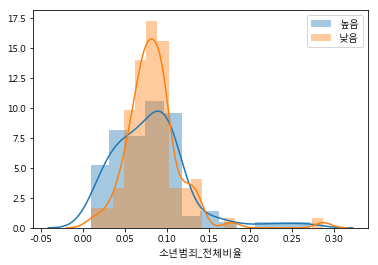

등분산 검정에 대한 p-value : 0.016750874780653895
등분산 검정에 대한 p-value가 0.05보다 작다
t-test에 대한 p-vlaue : 0.5421347651702833
T-test에 대한 p-value가 0.05보다 크므로 HO를 채택


In [81]:
con_check('group4','소년범죄_전체비율',sigungu_nxy)